# Blad VGG (based on Fisheries competition)

In this notebook we're going to investigate a range of different architectures for the [Kaggle fisheries competition](https://www.kaggle.com/c/the-nature-conservancy-fisheries-monitoring/).  The video states that vgg.py and ``vgg_ft()`` from utils.py have been updated to include VGG with batch normalization, but this is not the case.  We've instead created a new file [vgg_bn.py](https://github.com/fastai/courses/blob/master/deeplearning1/nbs/vgg16bn.py) and an additional method ``vgg_ft_bn()`` (which is already in utils.py) which we use in this notebook.

In [1]:
from theano.sandbox import cuda

WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: Tesla K80 (CNMeM is disabled, cuDNN 5103)


In [2]:
%matplotlib inline
import utils; reload(utils)
from utils import *
from __future__ import division, print_function

Using Theano backend.


In [22]:
path = "/home/ubuntu/fast-ai/data/blade_ho/"
model_path = '/home/ubuntu/fast-ai/data/blade_ho/models/'
batch_size=64
os.path.exists(model_path)

True

## Basic VGG

We start with our usual VGG approach.  We will be using VGG with batch normalization.  We explained how to add batch normalization to VGG in the [imagenet_batchnorm notebook](https://github.com/fastai/courses/blob/master/deeplearning1/nbs/imagenet_batchnorm.ipynb).  VGG with batch normalization is implemented in [vgg_bn.py](https://github.com/fastai/courses/blob/master/deeplearning1/nbs/vgg16bn.py), and there is a version of ``vgg_ft`` (our fine tuning function) with batch norm called ``vgg_ft_bn`` in [utils.py](https://github.com/fastai/courses/blob/master/deeplearning1/nbs/utils.py).

In [94]:
batches = get_batches(path+'train', batch_size=batch_size)
val_batches = get_batches(path+'valid', batch_size=batch_size*2, shuffle=False)

(val_classes, trn_classes, val_labels, trn_labels, 
    val_filenames, filenames, test_filenames) = get_classes(path)

Found 673 images belonging to 2 classes.
Found 100 images belonging to 2 classes.
Found 673 images belonging to 2 classes.
Found 100 images belonging to 2 classes.
Found 23 images belonging to 1 classes.


Sometimes it's helpful to have just the filenames, without the path.

In [95]:
raw_filenames = [f.split('/')[-1] for f in filenames]
raw_test_filenames = [f.split('/')[-1] for f in test_filenames]
raw_val_filenames = [f.split('/')[-1] for f in val_filenames]

### Initial model

First we create a simple fine-tuned VGG model to be our starting point.

In [96]:
from vgg16bn import Vgg16BN
model = vgg_ft_bn(2)

/home/ubuntu/anaconda2/lib/python2.7/site-packages/keras/layers/core.py:622: UserWarning: `output_shape` argument not specified for layer lambda_5 and cannot be automatically inferred with the Theano backend. Defaulting to output shape `(None, 3, 224, 224)` (same as input shape). If the expected output shape is different, specify it via the `output_shape` argument.
  .format(self.name, input_shape))


In [97]:
trn = get_data(path+'train')
val = get_data(path+'valid')

Found 673 images belonging to 2 classes.
Found 100 images belonging to 2 classes.


In [27]:
test = get_data(path+'test')

Found 23 images belonging to 1 classes.


In [9]:
save_array(path+'results/trn.dat', trn)
save_array(path+'results/val.dat', val)

In [10]:
save_array(path+'results/test.dat', test)

In [45]:
trn = load_array(path+'results/trn.dat')
val = load_array(path+'results/val.dat')

In [54]:
test = load_array(path+'results/test.dat')

In [28]:
gen = image.ImageDataGenerator()

In [29]:
model.compile(optimizer=Adam(1e-3),
       loss='categorical_crossentropy', metrics=['accuracy'])

In [30]:
model.fit(trn, trn_labels, batch_size=batch_size, nb_epoch=3, validation_data=(val, val_labels))

Train on 1137 samples, validate on 150 samples
Epoch 1/3
1137/1137 [==============================] - 30s - loss: 2.5351 - acc: 0.4591 - val_loss: 1.6177 - val_acc: 0.5000

In [21]:
model.save_weights(path+'results/ft1.h5')

### Precompute convolutional output

We pre-compute the output of the last convolution layer of VGG, since we're unlikely to need to fine-tune those layers. (All following analysis will be done on just the pre-computed convolutional features.)

In [50]:
model.load_weights(path+'results/ft1.h5')

In [31]:
conv_layers,fc_layers = split_at(model, Convolution2D)

In [32]:
conv_model = Sequential(conv_layers)

In [33]:
conv_feat = conv_model.predict(trn)
conv_val_feat = conv_model.predict(val)

In [34]:
conv_test_feat = conv_model.predict(test)

In [26]:
save_array(path+'results/conv_val_feat.dat', conv_val_feat)
save_array(path+'results/conv_feat.dat', conv_feat)

In [27]:
save_array(path+'results/conv_test_feat.dat', conv_test_feat)

In [53]:
conv_feat = load_array(path+'results/conv_feat.dat')
conv_val_feat = load_array(path+'results/conv_val_feat.dat')

In [829]:
conv_test_feat = load_array(path+'results/conv_test_feat.dat')

In [35]:
conv_val_feat.shape

(150, 512, 14, 14)

### Train model

We can now create our first baseline model - a simple 3-layer FC net.

In [40]:
def get_bn_layers(p):
    return [
        MaxPooling2D(input_shape=conv_layers[-1].output_shape[1:]),
        BatchNormalization(axis=1),
        Dropout(p/4),
        Flatten(),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(p),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(p/2),
        Dense(3, activation='softmax')
    ]

In [41]:
p=0.6

In [42]:
bn_model = Sequential(get_bn_layers(p))
bn_model.compile(Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [45]:
bn_model.fit(conv_feat, trn_labels, batch_size=batch_size, nb_epoch=3, 
             validation_data=(conv_val_feat, val_labels))

Train on 1137 samples, validate on 150 samples
Epoch 1/3
1137/1137 [==============================] - 0s - loss: 0.7879 - acc: 0.6772 - val_loss: 1.2780 - val_acc: 0.5333
Epoch 2/3
1137/1137 [==============================] - 0s - loss: 0.7754 - acc: 0.6843 - val_loss: 1.1593 - val_acc: 0.5467

In [46]:
bn_model.optimizer.lr = 1e-4

In [48]:
bn_model.fit(conv_feat, trn_labels, batch_size=batch_size, nb_epoch=7, 
             validation_data=(conv_val_feat, val_labels))

Train on 1137 samples, validate on 150 samples
Epoch 1/7
1137/1137 [==============================] - 0s - loss: 0.6355 - acc: 0.7397 - val_loss: 1.2497 - val_acc: 0.5133
Epoch 2/7
1137/1137 [==============================] - 0s - loss: 0.5380 - acc: 0.7696 - val_loss: 1.2761 - val_acc: 0.5467

In [38]:
bn_model.save_weights(path+'models/conv_512_6.h5')

In [49]:
bn_model.evaluate(conv_val_feat, val_labels)

150/150 [==============================] - 0s     


[1.2619052076339721, 0.49333333492279052]

In [774]:
bn_model.load_weights(path+'models/conv_512_6.h5')

## Multi-input

The images are of different sizes, which are likely to represent the boat they came from (since different boats will use different cameras). Perhaps this creates some data leakage that we can take advantage of to get a better Kaggle leaderboard position? To find out, first we create arrays of the file sizes for each image:

In [56]:
sizes = [PIL.Image.open(path+'train/'+f).size for f in filenames]
id2size = list(set(sizes))
size2id = {o:i for i,o in enumerate(id2size)}

In [58]:
import collections
collections.Counter(sizes)

Counter({(1192, 670): 165,
         (1244, 700): 20,
         (1276, 718): 188,
         (1280, 720): 1893,
         (1280, 750): 527,
         (1280, 924): 51,
         (1280, 974): 340,
         (1334, 750): 28,
         (1518, 854): 35,
         (1732, 974): 30})

Then we one-hot encode them (since we want to treat them as categorical) and normalize the data.

In [59]:
trn_sizes_orig = to_categorical([size2id[o] for o in sizes], len(id2size))

In [60]:
raw_val_sizes = [PIL.Image.open(path+'valid/'+f).size for f in val_filenames]
val_sizes = to_categorical([size2id[o] for o in raw_val_sizes], len(id2size))

In [61]:
trn_sizes = trn_sizes_orig-trn_sizes_orig.mean(axis=0)/trn_sizes_orig.std(axis=0)
val_sizes = val_sizes-trn_sizes_orig.mean(axis=0)/trn_sizes_orig.std(axis=0)

To use this additional "meta-data", we create a model with multiple input layers - `sz_inp` will be our input for the size information.

In [37]:
p=0.6

In [38]:
inp = Input(conv_layers[-1].output_shape[1:])
sz_inp = Input((len(id2size),))
bn_inp = BatchNormalization()(sz_inp)

x = MaxPooling2D()(inp)
x = BatchNormalization(axis=1)(x)
x = Dropout(p/4)(x)
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(p)(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(p/2)(x)
x = merge([x,bn_inp], 'concat')
x = Dense(8, activation='softmax')(x)

When we compile the model, we have to specify all the input layers in an array.

In [39]:
model = Model([inp, sz_inp], x)
model.compile(Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

And when we train the model, we have to provide all the input layers' data in an array.

In [40]:
model.fit([conv_feat, trn_sizes], trn_labels, batch_size=batch_size, nb_epoch=3, 
             validation_data=([conv_val_feat, val_sizes], val_labels))

Train on 3277 samples, validate on 500 samples
Epoch 1/3
3277/3277 [==============================] - 2s - loss: 1.1621 - acc: 0.6613 - val_loss: 0.6370 - val_acc: 0.8860
Epoch 2/3
3277/3277 [==============================] - 2s - loss: 0.3222 - acc: 0.8993 - val_loss: 0.2118 - val_acc: 0.9600
Epoch 3/3
3277/3277 [==============================] - 2s - loss: 0.1668 - acc: 0.9542 - val_loss: 0.1140 - val_acc: 0.9740


In [41]:
bn_model.optimizer.lr = 1e-4

In [42]:
bn_model.fit(conv_feat, trn_labels, batch_size=batch_size, nb_epoch=8, 
             validation_data=(conv_val_feat, val_labels))

Train on 3277 samples, validate on 500 samples
Epoch 1/8
3277/3277 [==============================] - 1s - loss: 0.0666 - acc: 0.9774 - val_loss: 0.0928 - val_acc: 0.9900
Epoch 2/8
3277/3277 [==============================] - 1s - loss: 0.0363 - acc: 0.9905 - val_loss: 0.0997 - val_acc: 0.9840
Epoch 3/8
3277/3277 [==============================] - 1s - loss: 0.0292 - acc: 0.9924 - val_loss: 0.0840 - val_acc: 0.9900
Epoch 4/8
3277/3277 [==============================] - 1s - loss: 0.0375 - acc: 0.9905 - val_loss: 0.0862 - val_acc: 0.9900
Epoch 5/8
3277/3277 [==============================] - 1s - loss: 0.0218 - acc: 0.9939 - val_loss: 0.1155 - val_acc: 0.9880
Epoch 6/8
3277/3277 [==============================] - 1s - loss: 0.0292 - acc: 0.9905 - val_loss: 0.1033 - val_acc: 0.9900
Epoch 7/8
3277/3277 [==============================] - 1s - loss: 0.0173 - acc: 0.9921 - val_loss: 0.1030 - val_acc: 0.9900
Epoch 8/8
3277/3277 [==============================] - 1s - loss: 0.0186 - acc: 0.993

The model did not show an improvement by using the leakage, other than in the early epochs. This is most likely because the information about what boat the picture came from is readily identified from the image itself, so the meta-data turned out not to add any additional information.

## Bounding boxes & multi output

### Import / view bounding boxes

A kaggle user has created bounding box annotations for each fish in each training set image. You can download them [from here](https://www.kaggle.com/c/the-nature-conservancy-fisheries-monitoring/forums/t/25902/complete-bounding-box-annotation). We will see if we can utilize this additional information. First, we'll load in the data, and keep just the largest bounding box for each image.

In [44]:
import ujson as json

In [45]:
anno_classes = ['alb', 'bet', 'dol', 'lag', 'other', 'shark', 'yft']

In [49]:
bb_json = {}
for c in anno_classes:
    j = json.load(open('{}annos/{}_labels.json'.format(path+'models/', c), 'r'))
    for l in j:
        if 'annotations' in l.keys() and len(l['annotations'])>0:
            bb_json[l['filename'].split('/')[-1]] = sorted(
                l['annotations'], key=lambda x: x['height']*x['width'])[-1]

In [50]:
bb_json['img_04908.jpg']

{u'class': u'rect',
 u'height': 246.75000000000074,
 u'width': 432.8700000000013,
 u'x': 465.3000000000014,
 u'y': 496.32000000000147}

In [51]:
file2idx = {o:i for i,o in enumerate(raw_filenames)}
val_file2idx = {o:i for i,o in enumerate(raw_val_filenames)}

For any images that have no annotations, we'll create an empty bounding box.

In [52]:
empty_bbox = {'height': 0., 'width': 0., 'x': 0., 'y': 0.}

In [53]:
for f in raw_filenames:
    if not f in bb_json.keys(): bb_json[f] = empty_bbox
for f in raw_val_filenames:
    if not f in bb_json.keys(): bb_json[f] = empty_bbox

Finally, we convert the dictionary into an array, and convert the coordinates to our resized 224x224 images.

In [54]:
bb_params = ['height', 'width', 'x', 'y']
def convert_bb(bb, size):
    bb = [bb[p] for p in bb_params]
    conv_x = (224. / size[0])
    conv_y = (224. / size[1])
    bb[0] = bb[0]*conv_y
    bb[1] = bb[1]*conv_x
    bb[2] = max(bb[2]*conv_x, 0)
    bb[3] = max(bb[3]*conv_y, 0)
    return bb

In [62]:
trn_bbox = np.stack([convert_bb(bb_json[f], s) for f,s in zip(raw_filenames, sizes)], 
                   ).astype(np.float32)
val_bbox = np.stack([convert_bb(bb_json[f], s) 
                   for f,s in zip(raw_val_filenames, raw_val_sizes)]).astype(np.float32)

Now we can check our work by drawing one of the annotations.

In [63]:
def create_rect(bb, color='red'):
    return plt.Rectangle((bb[2], bb[3]), bb[1], bb[0], color=color, fill=False, lw=3)

def show_bb(i):
    bb = val_bbox[i]
    plot(val[i])
    plt.gca().add_patch(create_rect(bb))

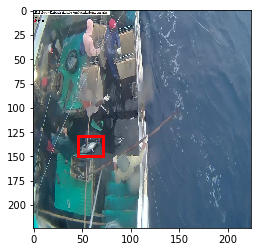

In [64]:
show_bb(0)

### Create & train model

Since we're not allowed (by the kaggle rules) to manually annotate the test set, we'll need to create a model that predicts the locations of the bounding box on each image. To do so, we create a model with multiple outputs: it will predict both the type of fish (the 'class'), and the 4 bounding box coordinates. We prefer this approach to only predicting the bounding box coordinates, since we hope that giving the model more context about what it's looking for will help it with both tasks.

In [65]:
p=0.6

In [66]:
inp = Input(conv_layers[-1].output_shape[1:])
x = MaxPooling2D()(inp)
x = BatchNormalization(axis=1)(x)
x = Dropout(p/4)(x)
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(p)(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(p/2)(x)
x_bb = Dense(4, name='bb')(x)
x_class = Dense(8, activation='softmax', name='class')(x)

Since we have multiple outputs, we need to provide them to the model constructor in an array, and we also need to say what loss function to use for each. We also weight the bounding box loss function down by 1000x since the scale of the cross-entropy loss and the MSE is very different.

In [67]:
model = Model([inp], [x_bb, x_class])
model.compile(Adam(lr=0.001), loss=['mse', 'categorical_crossentropy'], metrics=['accuracy'],
             loss_weights=[.001, 1.])

In [68]:
model.fit(conv_feat, [trn_bbox, trn_labels], batch_size=batch_size, nb_epoch=3, 
             validation_data=(conv_val_feat, [val_bbox, val_labels]))

Train on 3277 samples, validate on 500 samples
Epoch 1/3
3277/3277 [==============================] - 2s - loss: 6.1357 - bb_loss: 5025.6250 - class_loss: 1.1101 - bb_acc: 0.4443 - class_acc: 0.6680 - val_loss: 4.6933 - val_bb_loss: 4244.6398 - val_class_loss: 0.4487 - val_bb_acc: 0.5600 - val_class_acc: 0.9060

In [69]:
model.optimizer.lr = 1e-5

In [70]:
model.fit(conv_feat, [trn_bbox, trn_labels], batch_size=batch_size, nb_epoch=10, 
             validation_data=(conv_val_feat, [val_bbox, val_labels]))

Train on 3277 samples, validate on 500 samples
Epoch 1/10
3277/3277 [==============================] - 2s - loss: 3.6997 - bb_loss: 3581.6595 - class_loss: 0.1181 - bb_acc: 0.5911 - class_acc: 0.9673 - val_loss: 3.2435 - val_bb_loss: 3130.2575 - val_class_loss: 0.1132 - val_bb_acc: 0.5920 - val_class_acc: 0.9720

Excitingly, it turned out that the classification model is much improved by giving it this additional task. Let's see how well the bounding box model did by taking a look at its output.

In [71]:
pred = model.predict(conv_val_feat[0:10])

In [72]:
def show_bb_pred(i):
    bb = val_bbox[i]
    bb_pred = pred[0][i]
    plt.figure(figsize=(6,6))
    plot(val[i])
    ax=plt.gca()
    ax.add_patch(create_rect(bb_pred, 'yellow'))
    ax.add_patch(create_rect(bb))

The image shows that it can find fish that are tricky for us to see!

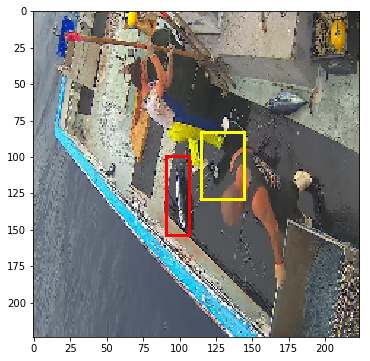

In [73]:
show_bb_pred(6)

In [74]:
model.evaluate(conv_val_feat, [val_bbox, val_labels])

416/500 [=======================>......] - ETA: 0s

[0.33589617013931272,
 229.15305029296874,
 0.10674311060458422,
 0.82400000047683719,
 0.98399999952316286]

In [75]:
model.save_weights(path+'models/bn_anno.h5')

In [57]:
model.load_weights(path+'models/bn_anno.h5')

## Larger size

### Set up data

Let's see if we get better results if we use larger images. We'll use 640x360, since it's the same shape as the most common size we saw earlier (1280x720), without being too big.

In [98]:
trn = get_data(path+'train', (360,640))
val = get_data(path+'valid', (360,640))

Found 673 images belonging to 2 classes.
Found 100 images belonging to 2 classes.


The image shows that things are much clearer at this size.

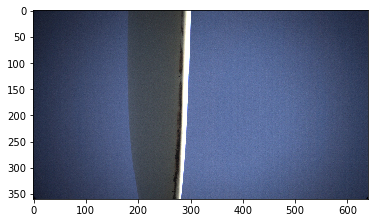

In [99]:
plot(trn[0])

In [100]:
test = get_data(path+'test', (360,640))

Found 23 images belonging to 1 classes.


In [101]:
save_array(path+'results/trn_640.dat', trn)
save_array(path+'results/val_640.dat', val)

In [102]:
save_array(path+'results/test_640.dat', test)

In [6]:
trn = load_array(path+'results/trn_640.dat')
val = load_array(path+'results/val_640.dat')

We can now create our VGG model - we'll need to tell it we're not using the normal 224x224 images, which also means it won't include the fully connected layers (since they don't make sense for non-default sizes). We will also remove the last max pooling layer, since we don't want to throw away information yet.

In [103]:
vgg640 = Vgg16BN((360, 640)).model
vgg640.pop()
vgg640.input_shape, vgg640.output_shape
vgg640.compile(Adam(), 'categorical_crossentropy', metrics=['accuracy'])

/home/ubuntu/anaconda2/lib/python2.7/site-packages/keras/layers/core.py:622: UserWarning: `output_shape` argument not specified for layer lambda_6 and cannot be automatically inferred with the Theano backend. Defaulting to output shape `(None, 3, 360, 640)` (same as input shape). If the expected output shape is different, specify it via the `output_shape` argument.
  .format(self.name, input_shape))


We can now pre-compute the output of the convolutional part of VGG.

In [104]:
conv_val_feat = vgg640.predict(val, batch_size=32, verbose=1)
conv_trn_feat = vgg640.predict(trn, batch_size=32, verbose=1)

673/673 [==============================] - 79s     

In [105]:
save_array(path+'results/conv_val_640.dat', conv_val_feat)
save_array(path+'results/conv_trn_640.dat', conv_trn_feat)

In [106]:
conv_test_feat = vgg640.predict(test, batch_size=32, verbose=1)

23/23 [==============================] - 2s


In [107]:
save_array(path+'results/conv_test_640.dat', conv_test_feat)

In [ ]:
conv_val_feat = load_array(path+'results/conv_val_640.dat')
conv_trn_feat = load_array(path+'results/conv_trn_640.dat')

In [868]:
conv_test_feat = load_array(path+'results/conv_test_640.dat')

### Fully convolutional net (FCN)

Since we're using a larger input, the output of the final convolutional layer is also larger. So we probably don't want to put a dense layer there - that would be a *lot* of parameters! Instead, let's use a fully convolutional net (FCN); this also has the benefit that they tend to generalize well, and also seems like a good fit for our problem (since the fish are a small part of the image).

In [108]:
conv_layers,_ = split_at(vgg640, Convolution2D)

I'm not using any dropout, since I found I got better results without it.

In [109]:
nf=128; p=0.

In [110]:
def get_lrg_layers():
    return [
        BatchNormalization(axis=1, input_shape=conv_layers[-1].output_shape[1:]),
        Convolution2D(nf,3,3, activation='relu', border_mode='same'),
        BatchNormalization(axis=1),
        MaxPooling2D(),
        Convolution2D(nf,3,3, activation='relu', border_mode='same'),
        BatchNormalization(axis=1),
        MaxPooling2D(),
        Convolution2D(nf,3,3, activation='relu', border_mode='same'),
        BatchNormalization(axis=1),
        MaxPooling2D((1,2)),
        Convolution2D(2,3,3, border_mode='same'),
        Dropout(p),
        GlobalAveragePooling2D(),
        Activation('softmax')
    ]

In [111]:
lrg_model = Sequential(get_lrg_layers())

In [112]:
lrg_model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
batchnormalization_23 (BatchNorm (None, 512, 22, 40)   2048        batchnormalization_input_3[0][0] 
____________________________________________________________________________________________________
convolution2d_87 (Convolution2D) (None, 128, 22, 40)   589952      batchnormalization_23[0][0]      
____________________________________________________________________________________________________
batchnormalization_24 (BatchNorm (None, 128, 22, 40)   512         convolution2d_87[0][0]           
____________________________________________________________________________________________________
maxpooling2d_36 (MaxPooling2D)   (None, 128, 11, 20)   0           batchnormalization_24[0][0]      
___________________________________________________________________________________________

In [119]:
lrg_model.compile(Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [120]:
lrg_model.fit(conv_trn_feat, trn_labels, batch_size=batch_size, nb_epoch=2, 
             validation_data=(conv_val_feat, val_labels))

Train on 673 samples, validate on 100 samples
Epoch 1/2
673/673 [==============================] - 2s - loss: 4.2348 - acc: 0.6761 - val_loss: 8.0590 - val_acc: 0.5000
Epoch 2/2
673/673 [==============================] - 2s - loss: 4.1619 - a

In [126]:
lrg_model.optimizer.lr=1e-7

In [128]:
lrg_model.fit(conv_trn_feat, trn_labels, batch_size=batch_size, nb_epoch=6, 
             validation_data=(conv_val_feat, val_labels))

Train on 673 samples, validate on 100 samples
Epoch 1/6
673/673 [==============================] - 2s - loss: 1.7019 - acc: 0.7370 - val_loss: 3.7703 - val_acc: 0.6100
Epoch 2/6
673/673 [==============================] - 2s - loss: 1.5012 - a

When I submitted the results of this model to Kaggle, I got the best single model results of any shown here (ranked 22nd on the leaderboard as at Dec-6-2016.)

In [129]:
lrg_model.save_weights(path+'models/lrg_nmp.h5')

In [870]:
lrg_model.load_weights(path+'models/lrg_nmp.h5')

In [130]:
lrg_model.evaluate(conv_val_feat, val_labels)

 96/100 [===========================>..] - ETA: 0s

[2.4304007244110108, 0.62]

In [131]:
import csv
#test_batches = get_batches(path + 'test', shuffle=False, target_size=(360, 640))
predicts = lrg_model.predict(conv_test_feat, batch_size=64)
#predicts = [x[1] for x in predicts]
#predicts = np.clip(predicts, 0.02, 0.98)
np.savetxt(path + 'results/' + 'predicts.csv', predicts, delimiter=',' , fmt='%1.17f')

In [132]:
test_batches = get_batches(path + 'test', shuffle=False)
wtr = csv.writer(open (path + 'results/' + 'filenames.csv', 'w'), delimiter=',', lineterminator='\n')
# for x in raw_test_filenames : wtr.writerow ([x])
for x in test_batches.filenames : wtr.writerow ([x])

Found 23 images belonging to 1 classes.


In [133]:
%%bash -s "$path"
cd $1/results/
~/fast-ai/scripts/clean_data.sh filenames.csv predicts.csv

,0.00000000000000000,1.00000000000000000
,0.00000000000000003,1.00000000000000000
,0.00000000022292836,1.00000000000000000
,0.00000036720865637,0.99999964237213135
,0.00032699332223274,0.99967300891876221
,0.00051594880642369,0.99948406219482422
,0.49336516857147217,0.50663483142852783
,0.55076569318771362,0.44923427700996399
,0.64603567123413086,0.35396435856819153
,0.84030175209045410,0.15969826281070709


Another benefit of this kind of model is that the last convolutional layer has to learn to classify each part of the image (since there's only an average pooling layer after). Let's create a function that grabs the output of this layer (which is the 4th-last layer of our model).

In [134]:
l = lrg_model.layers
conv_fn = K.function([l[0].input, K.learning_phase()], l[-4].output)

In [135]:
def get_cm(imp, label):
    conv = conv_fn([inp,0])[0, label]
    return scipy.misc.imresize(conv, (360,640), interp='nearest')

We have to add an extra dimension to our input since the CNN expects a 'batch' (even if it's just a batch of one).

In [136]:
inp = np.expand_dims(conv_val_feat[0], 0)
np.round(lrg_model.predict(inp)[0],2)

array([ 1.,  0.], dtype=float32)

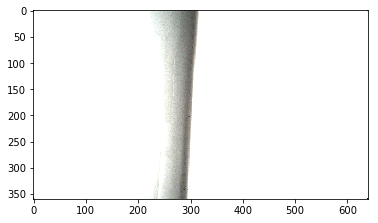

In [137]:
plt.imshow(to_plot(val[0]))

In [138]:
cm = get_cm(inp, 0)

The heatmap shows that (at very low resolution) the model is finding the fish!

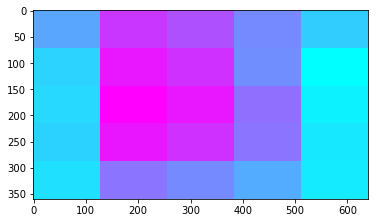

In [139]:
plt.imshow(cm, cmap="cool")

### All convolutional net heatmap

To create a higher resolution heatmap, we'll remove all the max pooling layers, and repeat the previous steps.

In [145]:
def get_lrg_layers():
    return [
        BatchNormalization(axis=1, input_shape=conv_layers[-1].output_shape[1:]),
        Convolution2D(nf,3,3, activation='relu', border_mode='same'),
        BatchNormalization(axis=1),
        Convolution2D(nf,3,3, activation='relu', border_mode='same'),
        BatchNormalization(axis=1),
        Convolution2D(nf,3,3, activation='relu', border_mode='same'),
        BatchNormalization(axis=1),
        Convolution2D(2,3,3, border_mode='same'),
        GlobalAveragePooling2D(),
        Activation('softmax')
    ]

In [146]:
lrg_model = Sequential(get_lrg_layers())

In [147]:
lrg_model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
batchnormalization_31 (BatchNorm (None, 512, 22, 40)   2048        batchnormalization_input_5[0][0] 
____________________________________________________________________________________________________
convolution2d_95 (Convolution2D) (None, 128, 22, 40)   589952      batchnormalization_31[0][0]      
____________________________________________________________________________________________________
batchnormalization_32 (BatchNorm (None, 128, 22, 40)   512         convolution2d_95[0][0]           
____________________________________________________________________________________________________
convolution2d_96 (Convolution2D) (None, 128, 22, 40)   147584      batchnormalization_32[0][0]      
___________________________________________________________________________________________

In [148]:
lrg_model.compile(Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [149]:
lrg_model.fit(conv_trn_feat, trn_labels, batch_size=batch_size, nb_epoch=2, 
             validation_data=(conv_val_feat, val_labels))

Train on 673 samples, validate on 100 samples
Epoch 1/2
673/673 [==============================] - 3s - loss: 0.6444 - acc: 0.6196 - val_loss: 2.1845 - val_acc: 0.5700
Epoch 2/2
673/673 [==============================] - 3s - loss: 0.4831 - a

In [150]:
lrg_model.optimizer.lr=1e-5

In [151]:
lrg_model.fit(conv_trn_feat, trn_labels, batch_size=batch_size, nb_epoch=6, 
             validation_data=(conv_val_feat, val_labels))

Train on 673 samples, validate on 100 samples
Epoch 1/6
673/673 [==============================] - 3s - loss: 0.4422 - acc: 0.7890 - val_loss: 3.3375 - val_acc: 0.5700
Epoch 2/6
673/673 [==============================] - 3s - loss: 0.4144 - a

In [152]:
lrg_model.save_weights(path+'models/lrg_0mp.h5')

In [20]:
lrg_model.load_weights(path+'models/lrg_0mp.h5')

#### Create heatmap

In [181]:
l = lrg_model.layers
conv_fn = K.function([l[2].input, K.learning_phase()], l[-3].output)

In [182]:
def get_cm2(imp, label):
    conv = conv_fn([inp,0])[0, label]
    return scipy.misc.imresize(conv, (360,640))

In [183]:
inp = np.expand_dims(conv_val_feat[2], 2)

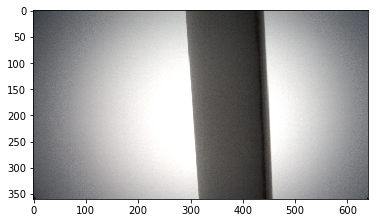

In [184]:
plt.imshow(to_plot(val[2]))

In [186]:
cm = get_cm2(inp, 0)

ValueError: GpuDnnConv images and kernel must have the same stack size

Apply node that caused the error: GpuDnnConv{algo='small', inplace=True}(GpuContiguous.0, GpuContiguous.0, GpuAllocEmpty.0, GpuDnnConvDesc{border_mode='half', subsample=(1, 1), conv_mode='conv', precision='float32'}.0, Constant{1.0}, Constant{0.0})
Toposort index: 86
Inputs types: [CudaNdarrayType(float32, 4D), CudaNdarrayType(float32, 4D), CudaNdarrayType(float32, 4D), <theano.gof.type.CDataType object at 0x7f21ba75f290>, Scalar(float32), Scalar(float32)]
Inputs shapes: [(512, 22, 1, 40), (128, 128, 3, 3), (512, 128, 1, 40), 'No shapes', (), ()]
Inputs strides: [(880, 40, 0, 1), (1152, 9, 3, 1), (5120, 40, 0, 1), 'No strides', (), ()]
Inputs values: ['not shown', 'not shown', 'not shown', <capsule object NULL at 0x7f21bf9b2c00>, 1.0, 0.0]
Inputs name: ('image', 'kernel', 'output', 'descriptor', 'alpha', 'beta')

Outputs clients: [[GpuElemwise{Composite{(i0 * ((i1 + i2) + Abs((i1 + i2))))}}[(0, 1)](CudaNdarrayConstant{[[[[ 0.5]]]]}, GpuDnnConv{algo='small', inplace=True}.0, GpuDimShuffle{x,0,x,x}.0)]]

HINT: Re-running with most Theano optimization disabled could give you a back-trace of when this node was created. This can be done with by setting the Theano flag 'optimizer=fast_compile'. If that does not work, Theano optimizations can be disabled with 'optimizer=None'.
HINT: Use the Theano flag 'exception_verbosity=high' for a debugprint and storage map footprint of this apply node.

In [173]:
cm = get_cm2(inp, 1)

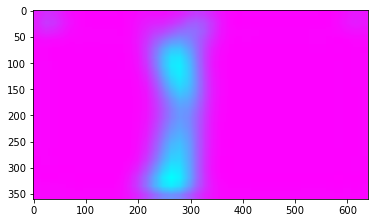

In [174]:
plt.imshow(cm, cmap="cool")

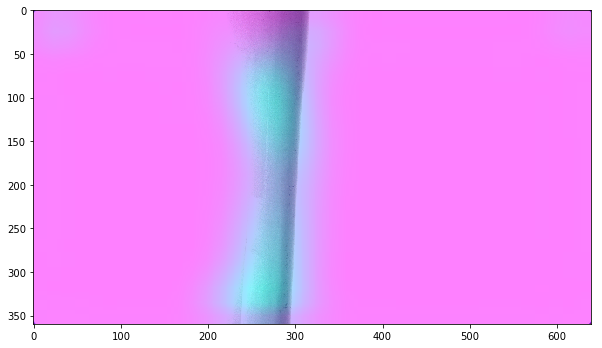

In [175]:
plt.figure(figsize=(10,10))
plot(val[0])
plt.imshow(cm, cmap="cool", alpha=0.5)

### Inception mini-net

Here's an example of how to create and use "inception blocks" - as you see, they use multiple different convolution filter sizes and concatenate the results together. We'll talk more about these next year.

In [198]:
def conv2d_bn(x, nb_filter, nb_row, nb_col, subsample=(1, 1)):
    x = Convolution2D(nb_filter, nb_row, nb_col,
                      subsample=subsample, activation='relu', border_mode='same')(x)
    return BatchNormalization(axis=1)(x)

In [208]:
def incep_block(x):
    branch1x1 = conv2d_bn(x, 32, 1, 1, subsample=(2, 2))
    branch5x5 = conv2d_bn(x, 24, 1, 1)
    branch5x5 = conv2d_bn(branch5x5, 32, 5, 5, subsample=(2, 2))

    branch3x3dbl = conv2d_bn(x, 32, 1, 1)
    branch3x3dbl = conv2d_bn(branch3x3dbl, 48, 3, 3)
    branch3x3dbl = conv2d_bn(branch3x3dbl, 48, 3, 3, subsample=(2, 2))

    branch_pool = AveragePooling2D(
        (3, 3), strides=(2, 2), border_mode='same')(x)
    branch_pool = conv2d_bn(branch_pool, 16, 1, 1)
    return merge([branch1x1, branch5x5, branch3x3dbl, branch_pool],
              mode='concat', concat_axis=1)

In [271]:
inp = Input(vgg640.layers[-1].output_shape[1:]) 
x = BatchNormalization(axis=1)(inp)
x = incep_block(x)
x = incep_block(x)
x = incep_block(x)
x = Dropout(0.75)(x)
x = Convolution2D(8,3,3, border_mode='same')(x)
x = GlobalAveragePooling2D()(x)
outp = Activation('softmax')(x)

In [272]:
lrg_model = Model([inp], outp)

In [273]:
lrg_model.compile(Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [274]:
lrg_model.fit(conv_trn_feat, trn_labels, batch_size=batch_size, nb_epoch=2, 
             validation_data=(conv_val_feat, val_labels))

Train on 3277 samples, validate on 500 samples
Epoch 1/2
3277/3277 [==============================] - 6s - loss: 1.3251 - acc: 0.5536 - val_loss: 1.4769 - val_acc: 0.5080
Epoch 2/2
3277/3277 [==============================] - 6s - loss: 0.4601 - acc: 0.8691 - val_loss: 0.9860 - val_acc: 0.7460


In [275]:
lrg_model.optimizer.lr=1e-5

In [277]:
lrg_model.fit(conv_trn_feat, trn_labels, batch_size=batch_size, nb_epoch=6, 
             validation_data=(conv_val_feat, val_labels))

Train on 3277 samples, validate on 500 samples
Epoch 1/6
3277/3277 [==============================] - 6s - loss: 0.0260 - acc: 0.9945 - val_loss: 0.2117 - val_acc: 0.9480
Epoch 2/6
3277/3277 [==============================] - 6s - loss: 0.0240 - acc: 0.9957 - val_loss: 0.3007 - val_acc: 0.9280
Epoch 3/6
3277/3277 [==============================] - 6s - loss: 0.0120 - acc: 0.9976 - val_loss: 0.2506 - val_acc: 0.9500
Epoch 4/6
3277/3277 [==============================] - 6s - loss: 0.0060 - acc: 0.9991 - val_loss: 0.2389 - val_acc: 0.9480
Epoch 5/6
3277/3277 [==============================] - 6s - loss: 0.0029 - acc: 1.0000 - val_loss: 0.2160 - val_acc: 0.9580
Epoch 6/6
3277/3277 [==============================] - 6s - loss: 0.0028 - acc: 0.9991 - val_loss: 0.2116 - val_acc: 0.9580


In [262]:
lrg_model.fit(conv_trn_feat, trn_labels, batch_size=batch_size, nb_epoch=10, 
             validation_data=(conv_val_feat, val_labels))

Train on 3277 samples, validate on 500 samples
Epoch 1/10
3277/3277 [==============================] - 6s - loss: 0.0029 - acc: 1.0000 - val_loss: 0.1610 - val_acc: 0.9540
Epoch 2/10
3277/3277 [==============================] - 6s - loss: 0.0016 - acc: 1.0000 - val_loss: 0.1313 - val_acc: 0.9540
Epoch 3/10
3277/3277 [==============================] - 6s - loss: 0.0995 - acc: 0.9707 - val_loss: 0.4845 - val_acc: 0.8760
Epoch 4/10
3277/3277 [==============================] - 6s - loss: 0.1335 - acc: 0.9551 - val_loss: 0.3103 - val_acc: 0.9300
Epoch 5/10
3277/3277 [==============================] - 6s - loss: 0.0634 - acc: 0.9780 - val_loss: 0.2923 - val_acc: 0.9340
Epoch 6/10
3277/3277 [==============================] - 6s - loss: 0.0205 - acc: 0.9930 - val_loss: 0.2316 - val_acc: 0.9500
Epoch 7/10
3277/3277 [==============================] - 6s - loss: 0.0049 - acc: 0.9997 - val_loss: 0.2048 - val_acc: 0.9660
Epoch 8/10
3277/3277 [==============================] - 6s - loss: 0.0016 - ac

In [110]:
lrg_model.save_weights(path+'models/lrg_nmp.h5')

In [153]:
lrg_model.load_weights(path+'models/lrg_nmp.h5')

## Pseudo-labeling

In [210]:
preds = model.predict([conv_test_feat, test_sizes], batch_size=batch_size*2)

In [212]:
gen = image.ImageDataGenerator()

In [214]:
test_batches = gen.flow(conv_test_feat, preds, batch_size=16)

In [215]:
val_batches = gen.flow(conv_val_feat, val_labels, batch_size=4)

In [217]:
batches = gen.flow(conv_feat, trn_labels, batch_size=44)

In [292]:
mi = MixIterator([batches, test_batches, val_batches)

In [220]:
bn_model.fit_generator(mi, mi.N, nb_epoch=8, validation_data=(conv_val_feat, val_labels))

Epoch 1/8
4833/4777 [==============================] - 4s - loss: 0.2538 - acc: 0.9462 - val_loss: 0.1313 - val_acc: 0.9700
Epoch 2/8
 192/4777 [>.............................] - ETA: 2s - loss: 0.1972 - acc: 0.9635

/usr/local/lib/python2.7/dist-packages/keras/engine/training.py:1494: UserWarning: Epoch comprised more than `samples_per_epoch` samples, which might affect learning results. Set `samples_per_epoch` correctly to avoid this warning.
  warnings.warn('Epoch comprised more than '


4833/4777 [==============================] - 4s - loss: 0.2231 - acc: 0.9491 - val_loss: 0.0820 - val_acc: 0.9820
Epoch 3/8
4833/4777 [==============================] - 3s - loss: 0.1860 - acc: 0.9545 - val_loss: 0.0580 - val_acc: 0.9840
Epoch 4/8
4833/4777 [==============================] - 3s - loss: 0.1559 - acc: 0.9663 - val_loss: 0.0521 - val_acc: 0.9840
Epoch 5/8
4825/4777 [==============================] - 3s - loss: 0.1366 - acc: 0.9693 - val_loss: 0.0422 - val_acc: 0.9840
Epoch 6/8
4833/4777 [==============================] - 3s - loss: 0.1303 - acc: 0.9704 - val_loss: 0.0195 - val_acc: 0.9940
Epoch 7/8
4833/4777 [==============================] - 3s - loss: 0.1283 - acc: 0.9708 - val_loss: 0.0133 - val_acc: 0.9940
Epoch 8/8
4833/4777 [==============================] - 4s - loss: 0.1199 - acc: 0.9752 - val_loss: 0.0247 - val_acc: 0.9900


## Submit

In [821]:
def do_clip(arr, mx): return np.clip(arr, (1-mx)/7, mx)

In [829]:
lrg_model.evaluate(conv_val_feat, val_labels, batch_size*2)

500/500 [==============================] - 0s     


[0.11417267167568207, 0.97199999332427978]

In [851]:
preds = model.predict(conv_test_feat, batch_size=batch_size)

In [852]:
preds = preds[1]

In [25]:
test = load_array(path+'results/test_640.dat')

In [5]:
test = load_array(path+'results/test.dat')

In [26]:
preds = conv_model.predict(test, batch_size=32)

In [853]:
subm = do_clip(preds,0.82)

In [854]:
subm_name = path+'results/subm_bb.gz'

In [855]:
# classes = sorted(batches.class_indices, key=batches.class_indices.get)
classes = ['ALB', 'BET', 'DOL', 'LAG', 'NoF', 'OTHER', 'SHARK', 'YFT']

In [856]:
submission = pd.DataFrame(subm, columns=classes)
submission.insert(0, 'image', raw_test_filenames)
submission.head()

,image,ALB,BET,DOL,LAG,NoF,OTHER,SHARK,YFT
0,img_00005.jpg,0.025714,0.025714,0.025714,0.025714,0.820000,0.025714,0.025714,0.025714
1,img_00007.jpg,0.820000,0.025714,0.025714,0.025714,0.025714,0.025714,0.025714,0.025714
2,img_00009.jpg,0.820000,0.025714,0.025714,0.025714,0.025714,0.025714,0.025714,0.025714
3,img_00018.jpg,0.457916,0.025714,0.025714,0.025714,0.025714,0.539635,0.025714,0.025714
4,img_00027.jpg,0.820000,0.025714,0.025714,0.025714,0.025714,0.025714,0.025714,0.102664


In [857]:
submission.to_csv(subm_name, index=False, compression='gzip')

In [858]:
FileLink(subm_name)

/data/jhoward/fast-image/nbs/data/fish/results/subm_bb.gz